FOLLOW UP ANALYSIS of indices [COMPLETE and little conclusive]

How can we predict the costs that are going to follow the damages? For this data, though it reveals that wildfire incidents and damage are in an increasing trend, it is not possible to build a meaningful regression model for this data because it is too scattered and uncorrelated to cost.

In [2]:
import pandas as pd
import numpy as np
import joblib
df = pd.read_csv("../DATASETS/calafterdamage.csv")
df

,Incident_ID,Date,Location,Area_Burned (Acres),Homes_Destroyed,Businesses_Destroyed,Vehicles_Damaged,Injuries,Fatalities,Estimated_Financial_Loss (Million $),Cause
0,INC1000,2020-11-22,Sonoma County,14048,763,474,235,70,19,2270.57,Lightning
1,INC1001,2021-09-23,Sonoma County,33667,1633,4,263,100,2,1381.14,Lightning
2,INC1002,2022-02-10,Shasta County,26394,915,291,31,50,6,2421.96,Human Activity
3,INC1003,2021-05-17,Sonoma County,20004,1220,128,34,28,0,3964.16,Unknown
4,INC1004,2021-09-22,Sonoma County,40320,794,469,147,0,15,1800.09,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
95,INC1095,2018-01-16,Mendocino County,13112,1468,46,281,89,17,4008.58,Human Activity
96,INC1096,2022-07-07,Shasta County,39209,710,282,189,34,14,376.72,Human Activity
97,INC1097,2016-05-18,Shasta County,11863,702,9,40,100,1,1474.78,Human Activity
98,INC1098,2014-06-24,Napa Valley,1338,1619,262,293,94,3,3308.74,Human Activity


We will need a regression model that takes the damage counts as inputs and outputs the cost. We should also enable the option to not have the user input a value, in which the sklearn model will simply impute a valude.

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df.dropna()
cols = list(df.columns)
print(cols)

['Incident_ID', 'Date', 'Location', 'Area_Burned (Acres)', 'Homes_Destroyed', 'Businesses_Destroyed', 'Vehicles_Damaged', 'Injuries', 'Fatalities', 'Estimated_Financial_Loss (Million $)', 'Cause']


In [ ]:
feature_columns = ['Location', 'Area_Burned (Acres)', 'Homes_Destroyed', 'Businesses_Destroyed', 'Vehicles_Damaged', 'Injuries', 'Fatalities', 'Cause'] #all colnames
focus_columns = ['Area_Burned (Acres)'] #colnames to focus on
outcome = 'Estimated_Financial_Loss (Million $)' #target
later = ['Homes_Destroyed', 'Businesses_Destroyed', 'Vehicles_Damaged', 'Injuries', 'Fatalities', 'Estimated_Financial_Loss (Million $)']
X = df[focus_columns]
y = df[outcome]

imputer = SimpleImputer(strategy='mean') #fill in missing values with mean
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Model trained to predict '{target_feature}'")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

perf[row].append(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print("hey")
print(perf[row])
    
    return model

We need to check the data for unusual points that could skew the overall.

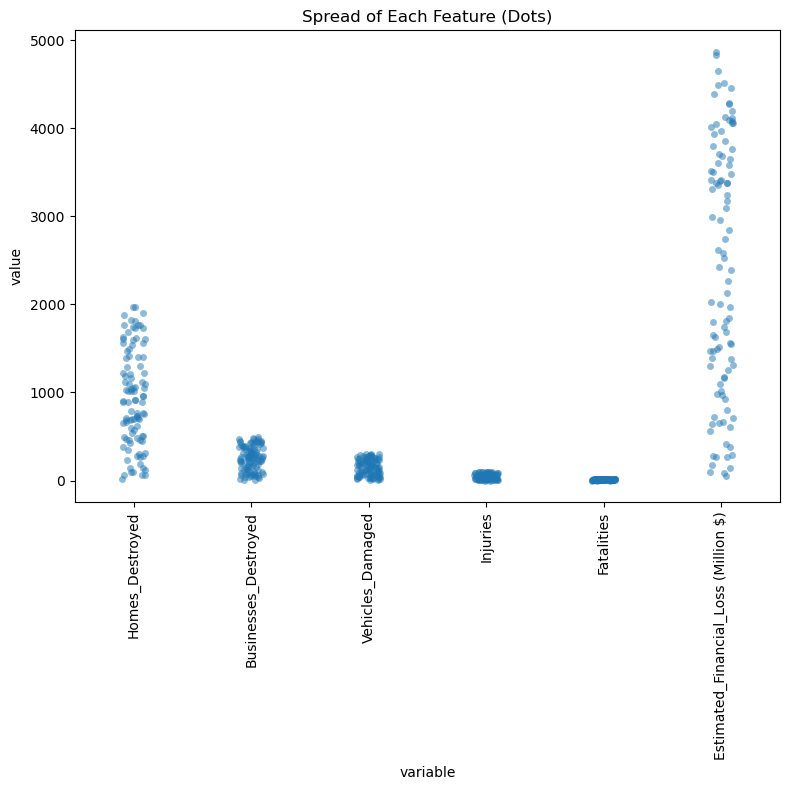

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(8, 8))
df_melt = pd.melt(df[focus_columns[1:]])
sns.stripplot(x="variable", y="value", data=df_melt, jitter=True, alpha=0.5)
plt.xticks(rotation=90)
plt.title("Spread of Each Feature (Dots)")
plt.tight_layout()
plt.show()

Lets see if a meaningful linear regression can be found

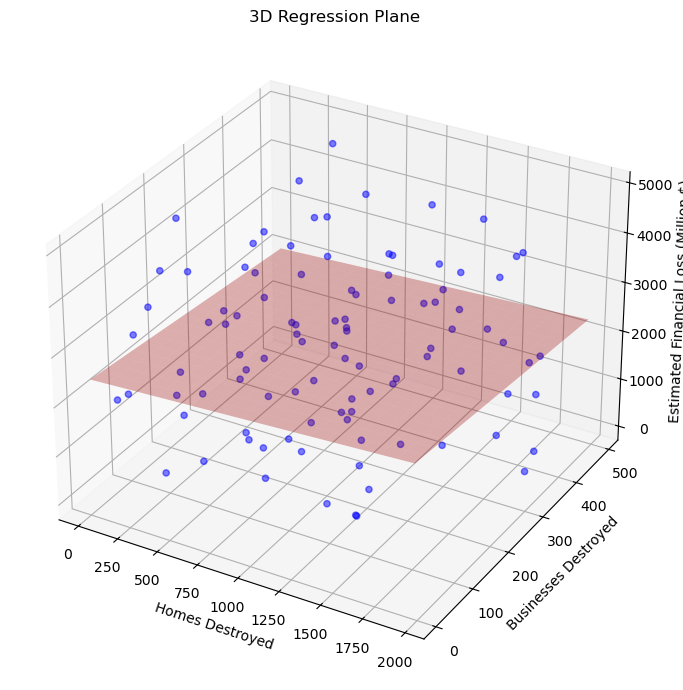

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression

# Select features and target
X = df[["Homes_Destroyed", "Businesses_Destroyed"]].values
y = df["Estimated_Financial_Loss (Million $)"].values

# Fit regression model
model = LinearRegression()
model.fit(X, y)

# Create grid for the plane
x_surf, y_surf = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 20),
    np.linspace(X[:,1].min(), X[:,1].max(), 20)
)
z_surf = model.predict(np.column_stack([x_surf.ravel(), y_surf.ravel()])).reshape(x_surf.shape)

# Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, color='blue', alpha=0.5, label='Data')
ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.3, label='Regression Plane')

ax.set_xlabel('Homes Destroyed')
ax.set_ylabel('Businesses Destroyed')
ax.set_zlabel('Estimated Financial Loss (Million $)')
plt.title('3D Regression Plane')
plt.tight_layout()
plt.show()

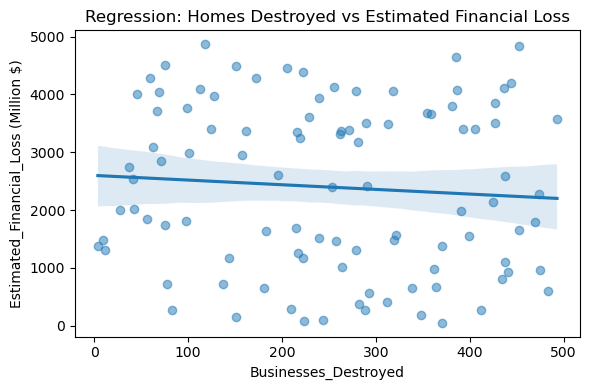

In [13]:
plt.figure(figsize=(6, 4))
sns.regplot(
    x="Businesses_Destroyed",
    y="Estimated_Financial_Loss (Million $)",
    data=df,
    scatter_kws={'alpha':0.5}
)
plt.title("Regression: Homes Destroyed vs Estimated Financial Loss")
plt.tight_layout()
plt.show()

Lets search for the regression model that will be best for our data. We should test the ability of each regression model for each target feature

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(max_iter=1000)
]

#because I want to be able to flexibly target a feature, lets create a regression train function for any target
def train_dynamic_regression(df, target_feature, correct_model, perf, row):
    X = df.drop(columns=[target_feature, "Area_Burned (Acres)", "Incident_ID", "Date", "Location", "Cause"]) #
    y = df[target_feature]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = correct_model
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model trained to predict '{target_feature}'")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    perf[row].append(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
    print("hey")
    print(perf[row])
    
    return model

In [18]:
performance = [[]]
mod = train_dynamic_regression(df, "Estimated_Financial_Loss (Million $)", RandomForestRegressor(), performance, 0)

Model trained to predict 'Estimated_Financial_Loss (Million $)'
Mean Squared Error: 2624331.953740699
R-squared: -0.3490502853583115
hey
[-2266978.016448443]


In [15]:
performance = [[]]
r = 0
for model in models:
    for feature in focus_columns:
        print("Model: ", model, " / Feature: ", feature)
        train_dynamic_regression(df, feature, model, performance, r)
    performance.append(([]))
    r+=1



Model:  LinearRegression()  / Feature:  Area_Burned (Acres)
Model trained to predict 'Area_Burned (Acres)'
Mean Squared Error: 171240838.62421864
R-squared: -0.08632562898978158
hey
[-229064202.6282452]
Model:  Ridge()  / Feature:  Area_Burned (Acres)
Model trained to predict 'Area_Burned (Acres)'
Mean Squared Error: 170951955.52436623
R-squared: -0.08449299889013373
hey
[-229058875.12569007]
Model:  Lasso()  / Feature:  Area_Burned (Acres)
Model trained to predict 'Area_Burned (Acres)'
Mean Squared Error: 171222134.86275434
R-squared: -0.08620697519434106
hey
[-229062562.0850684]
Model:  ElasticNet()  / Feature:  Area_Burned (Acres)
Model trained to predict 'Area_Burned (Acres)'
Mean Squared Error: 164932458.3079831
R-squared: -0.04630623133908518
hey
[-228854684.43730912]
Model:  RandomForestRegressor()  / Feature:  Area_Burned (Acres)
Model trained to predict 'Area_Burned (Acres)'
Mean Squared Error: 173658295.40548
R-squared: -0.10166160421367265
hey
[-239371203.138616]
Model:  Gra

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_netwo

hey
[-253971662.50435153]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:
performance

[[-229064202.6282452,
  -335309.67099994316,
  -21443.38022282151,
  -8285.166623700228,
  -970.2073492520852,
  -34.59892241142085],
 [-229058875.12569007,
  -335305.8269215267,
  -21443.05454266629,
  -8285.02030710369,
  -970.2009140115588,
  -34.59891294063888],
 [-229062562.0850684,
  -335289.8025165736,
  -21426.760366244824,
  -8283.217247227298,
  -968.2742816764761,
  -34.51372782808621],
 [-228854684.43730912,
  -335150.4654870883,
  -21422.473422336396,
  -8278.624800409476,
  -968.9336432340357,
  -34.5529765769493],
 [-240487482.06263798,
  -353038.25796200003,
  -22775.586614,
  -9347.626762000002,
  -943.796977,
  -36.86959],
 [-293903763.0650692,
  -470037.6918033582,
  -27797.22339976642,
  -12271.867993603319,
  -1016.7671124276267,
  -43.885557610313974],
 [-244746663.00539303,
  -369956.412384,
  -23810.774656,
  -9330.653203,
  -932.0422090000002,
  -37.661384000000005],
 [-208979865.22775823,
  -296610.33924347564,
  -19146.73034321824,
  -7839.582628373661,
  -91

In [14]:
target_feature = 'Estimated_Financial_Loss (Million $)'
model = train_dynamic_regression(df, target_feature)

Model trained to predict 'Estimated_Financial_Loss (Million $)'
Mean Squared Error: 2464817.601438336
R-squared: -0.26705117614291085


Linear Regressor: Model trained to predict 'Estimated_Financial_Loss (Million $)'
Mean Squared Error: 2088188.523564085
R-squared: -0.07344321269291099

Random Forest Regressor: Model trained to predict 'Estimated_Financial_Loss (Million $)'
Mean Squared Error: 2464817.601438336
R-squared: -0.26705117614291085

Lets try an example of using it. First without an imputer.

In [15]:
for i in range(50):
    random_row = df.sample(n=1, random_state=i)
    actual_value = random_row[target_feature].values[0]
    features = random_row.drop(columns=[target_feature, "Incident_ID", "Date", "Location", "Cause"]).values

    features_interrupted = features.copy()
    print(features_interrupted)
    features = scaler.transform(features)
    print(features)

    predicted_value = model.predict(features)[0]

    print(f"Actual Value: {actual_value}")
    print(f"Predicted Value: {predicted_value}")
    print(f"Difference: {abs(actual_value - predicted_value)}")
    print("---------------------")

[[14713   465    56   163    59    10]]
[[-0.8337964  -0.80316786 -1.33851556  0.07040311  0.53517112  0.08327105]]
Actual Value: 1840.53
Predicted Value: 2112.9123999999993
Difference: 272.3823999999993
---------------------
[[6620 1054  354   13   16   15]]
[[-1.38903005  0.27911507  0.83876412 -1.66437578 -0.91101007  0.98349864]]
Actual Value: 3685.18
Predicted Value: 2775.3312999999994
Difference: 909.8487000000005
---------------------
[[18920   896   144   200    35     6]]
[[-0.5451682  -0.0112087  -0.69556049  0.49831524 -0.27199978 -0.63691102]]
Actual Value: 1177.54
Predicted Value: 2000.010000000001
Difference: 822.4700000000009
---------------------
[[2047 1401   75  153   37    9]]
[[-1.70276828  0.91672488 -1.19969572 -0.04524882 -0.20473554 -0.09677447]]
Actual Value: 4508.65
Predicted Value: 3874.3551000000034
Difference: 634.2948999999962
---------------------
[[36784   461   215   195    33     9]]
[[ 0.68042107 -0.81051783 -0.17681265  0.44048927 -0.33926402 -0.0967

Then with an imputer.

In [ ]:
random_row = df.sample(n=1, random_state=i)
actual_value = random_row[target_feature].values[0]
features = random_row.drop(columns=[target_feature, "Incident_ID", "Date", "Location", "Cause"]).values
features_interrupted = features.copy()
print(features_interrupted)
features = scaler.transform(features)
print(features)

predicted_value = model.predict(features)[0]

print(f"Actual Value: {actual_value}")
print(f"Predicted Value: {predicted_value}")
print(f"Difference: {abs(actual_value - predicted_value)}")
print("---------------------")

random_row = df.sample(n=1, random_state=40)
actual_value = random_row[target_feature].values[0]
features = random_row.drop(columns=[target_feature, "Incident_ID", "Date", "Location", "Cause"]).values

features_interrupted = list(features.copy()[0])
print(features_interrupted)
features_interrupted[1] = np.nan
features_interrupted[4] = np.nan
print(features_interrupted)
print()

features_interrupted = np.array(features_interrupted).reshape(1, -1)
features = imputer.transform(features_interrupted)
features = scaler.transform(features)

imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
imputer.fit(df[focus_columns])

features = imputer.transform(features_interrupted)
features = scaler.transform(features)
print(features)

predicted_value = model.predict(features)[0]

print(f"Actual Value: {actual_value}")
print(f"Predicted Value: {predicted_value}")
print(f"Difference: {abs(actual_value - predicted_value)}")

joblib.dump(model, 'regression_model.pkl')

[[9866  705  101    5    4   14]]
[[-1.16633285 -0.36216972 -1.00973172 -1.75689732 -1.31459553  0.80345312]]
Actual Value: 2987.13
Predicted Value: 2740.561297584057
Difference: 246.56870241594333
---------------------
[41584, 1609, 12, 212, 42, 7]
[41584, nan, 12, 212, nan, 7]

[[ 1.00973301  0.07311382 -1.6599931   0.63709755 -0.03522965 -0.4568655 ]]
Actual Value: 1314.42
Predicted Value: 2571.835927571749
Difference: 1257.4159275717489


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


['regression_model.pkl']